In [2]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import pandas as pd
from scipy import stats

%matplotlib inline

In [31]:
p = np.repeat([.75, .75, .75, .25, .75, .25], 18)
env= stats.binom.rvs(1, p)
choose = list(map(bool, env))

observed_data = pd.DataFrame({"choose": choose, 
                              "index" : range(len(env))})

with pm.Model() as bayesian_lerner_model:
    k = pm.Normal("k", mu = 1, sigma = 0.5, testval = 0.6)
    k_ = pm.Deterministic('k_cap', pm.math.exp(k))
    v = pm.GaussianRandomWalk("v", mu = 0.07, sigma = k_, testval = 0.05, shape = len(env))
    v_ = pm.Deterministic('v_cap', pm.math.exp(v))

    r = []
    for ti in range(len(env)):
        if ti == 0:
            # Testvals are used to prevent -inf initial probability
            r.append(pm.Beta(f'r{ti}', 1, 1))
        else: 
            w = r[ti-1]
            k = 1 / v_[ti-1]
            r.append(pm.Beta(f'r{ti}', alpha=w*(k-2) + 1, beta=(1-w)*(k-2) + 1, testval = 0.5))

    r = pm.Deterministic('r', pm.math.stack(r))
    y = pm.Bernoulli("y", p = r, observed = env)
    
    trace = pm.sample(return_inferencedata=True, init="adapt_diag")

<ipython-input-31-20d62c8d44ef>:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(init="adapt_diag")
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r107, r106, r105, r104, r103, r102, r101, r100, r99, r98, r97, r96, r95, r94, r93, r92, r91, r90, r89, r88, r87, r86, r85, r84, r83, r82, r81, r80, r79, r78, r77, r76, r75, r74, r73, r72, r71, r70, r69, r68, r67, r66, r65, r64, r63, r62, r61, r60, r59, r58, r57, r56, r55, r54, r53, r52, r51, r50, r49, r48, r47, r46, r45, r44, r43, r42, r41, r40, r39, r38, r37, r36, r35, r34, r33, r32, r31, r30, r29, r28, r27, r26, r25, r24, r23, r22, r21, r20, r19, r18, r17, r16, r15, r14, r13, r12, r11, r10, r9, r8, r7, r6, r5, r4, r3, r2, r1, r0, v, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 427 seconds.
There were 675 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6710812019903784, but should be close to 0.8. Try to increase the number of tuning steps.
There were 744 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4953614086875049, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.02501936745525716, but should be close to 0.8. Try to increase the number of tuning steps.
There were 553 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated n

In [ ]:
p = np.repeat([.75, .75, .75, .25, .75, .25], 18)
env= stats.binom.rvs(1, p)
choose = list(map(bool, env))

observed_data = pd.DataFrame({"choose": choose, 
                              "index" : range(len(env))})

with pm.Model() as bayesian_lerner_model:
    k = pm.Normal("k", mu = 1, sigma = 0.5, testval = 0.6)
    k_ = pm.Deterministic('k_cap', pm.math.exp(k))
    v = pm.GaussianRandomWalk("v", mu = 0.07, sigma = k_, testval = 0.05, shape = len(env))
    v_ = pm.Deterministic('v_cap', pm.math.exp(v))

    r = []
    for ti in range(len(env)):
        if ti == 0:
            # Testvals are used to prevent -inf initial probability
            r.append(pm.Beta(f'r{ti}', 1, 1))
        else: 
            w = r[ti-1]
            k = 1 / v_[ti-1]
            r.append(pm.Beta(f'r{ti}', alpha=w*(k-2) + 1, beta=(1-w)*(k-2) + 1, testval = 0.5))

    r = pm.Deterministic('r', pm.math.stack(r))
    y = pm.Bernoulli("y", p = r, observed = env)
    
    trace = pm.sample(return_inferencedata=True, init="adapt_diag")

In [24]:
# plot
import matplotlib.pyplot as plt
import arviz as az

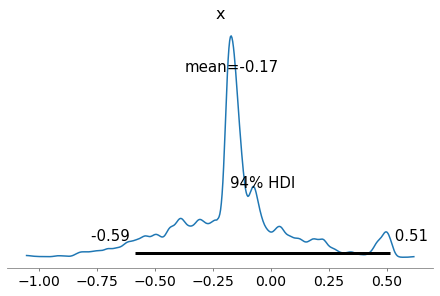

In [33]:
az.plot_posterior(trace['k']);

/Users/dddd1007/anaconda3/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (4000) than draws (108). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


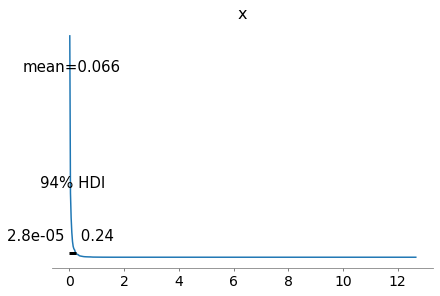

In [35]:
az.plot_posterior(trace['v_cap']);

/Users/dddd1007/anaconda3/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (4000) than draws (108). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


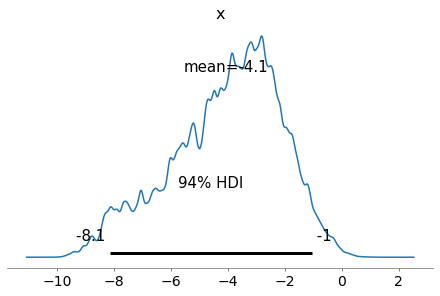

In [36]:
az.plot_posterior(trace['v']);

/Users/dddd1007/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


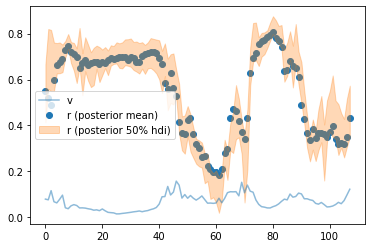

In [51]:
hdi = az.hdi(trace['r'], hdi_prob=.50)
x = range(len(env))
plt.scatter(x, trace['r'].mean(0), label='r (posterior mean)')
plt.fill_between(x, hdi[:, 0], hdi[:, 1], color='C1', alpha=.3, label='r (posterior 50% hdi)')
plt.plot(x, np.mean(trace['v_cap'], axis = 0), alpha = 0.5, label = 'v')
plt.legend();

In [50]:
plt.plot(x, np.mean(trace['v_cap'], axis = 0), alpha = 0.5, label = 'v')

NameError: name 'green' is not defined

In [47]:
import sys
import numpy as np

sys.path.append("/Users/dddd1007/project2git/discover_k_of_bayesian_learner/helper_tools")

import optlearner

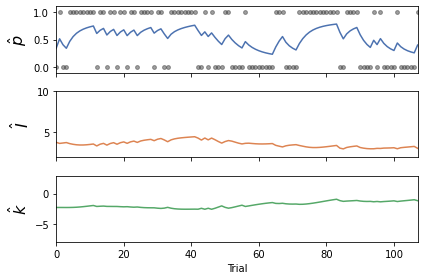

In [48]:
v_learner = optlearner.VolatilityLearner()
v_learner.reset()
v_learner.fit(env)
v_learner.plot_history()

In [6]:
p = np.repeat([.75, .75, .75, .25, .75, .25], 18)
env = stats.binom.rvs(1, p)
choose = list(map(bool, env))

observed_data = pd.DataFrame({"choose": choose, 
                              "index" : range(len(env))})

import theano.tensor as T

with pm.Model() as bayesian_lerner_model:
    k  = pm.Normal("k", mu = 1, sigma = 0.5, testval = 0.6)
    k_ = pm.Deterministic('k_hat', pm.math.exp(k))
    v  = pm.GaussianRandomWalk("v", mu = 0.07, sigma = k_, testval = 0.05, shape = len(env))
    #v_ = pm.Deterministic('v_hat', pm.math.exp(v))

    r0 = pm.Beta('r0', mu = 1, sigma = 1)
    step = T.as_tensor_variable(np.array(range(len(env))))
    def update_r(v_, step, r0):
        w = r0
        k = 1 / v
        r1 = pm.Beta('r'+str(step), alpha=w*(k-2) + 1, beta=(1-w)*(k-2) + 1, testval = 0.5)
        return r1
    
    result, updates = theano.scan(fn = update_r,
                                  sequences = [v,step],
                                  outputs_info = r0)
    
    r = pm.Deterministic('r', pm.math.stack(result))
    y = pm.Bernoulli("y", p = result, observed = env)
    
    trace = pm.sample(init="adapt_diag")

/Users/dddd1007/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in subtract
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


MissingInputError: Input 1 of the graph (indices start from 0), used to compute Elemwise{sub,no_inplace}(TensorConstant{1}, r0[t-1]), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.
 
Backtrace when that variable is created:

  File "/Users/dddd1007/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/dddd1007/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
    result = self._run_cell(
  File "/Users/dddd1007/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
    return runner(coro)
  File "/Users/dddd1007/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/dddd1007/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/dddd1007/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/Users/dddd1007/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-5b5002afd8d8>", line 24, in <module>
    result, updates = theano.scan(fn = update_r,


In [3]:
p = np.repeat([.75, .75, .75, .25, .75, .25], 18)
env = stats.binom.rvs(1, p)
choose = list(map(bool, env))

observed_data = pd.DataFrame({"choose": choose, 
                              "index" : range(len(env))})

with pm.Model() as bayesian_lerner_model:
    k  = pm.Normal("k", mu = 1, sigma = 0.5, testval = 0.6)
    k_ = pm.Deterministic('k_cap', pm.math.exp(k))
    v  = pm.GaussianRandomWalk("v", mu = 0.07, sigma = k_, testval = 0.05, shape = len(env))
    v_ = pm.Deterministic('v_cap', pm.math.exp(v))
    logit_r = pm.GaussianRandomWalk('logit_r', mu=0, sigma=v_, shape=len(env))
    r = pm.Deterministic('r', pm.math.invlogit(logit_r))

    y = pm.Bernoulli("y", p = r, observed = env)
    
    trace = pm.sample(init="adapt_diag")

<ipython-input-3-783457502445>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(init="adapt_diag")
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logit_r, v, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 630 divergences after tuning. Increase `target_accept` or reparameterize.
There were 641 divergences after tuning. Increase `target_accept` or reparameterize.
There were 720 divergences after tuning. Increase `target_accept` or reparameterize.
There were 494 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/dddd1007/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


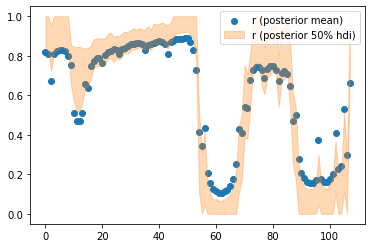

In [5]:
import matplotlib.pyplot as plt
import arviz as az
hdi = az.hdi(trace['r'], hdi_prob=.50)
x = range(len(env))
plt.scatter(x, trace['r'].mean(0), label='r (posterior mean)')
plt.fill_between(x, hdi[:, 0], hdi[:, 1], color='C1', alpha=.3, label='r (posterior 50% hdi)')
# plt.plot(x, np.mean(trace['v_cap'], axis = 0), alpha = 0.5, label = 'v')
plt.legend();

尝试理解 Theano scan

In [5]:
p = np.repeat([.75, .75, .75, .25, .75, .25], 18)
env = stats.binom.rvs(1, p)
choose = list(map(bool, env))

observed_data = pd.DataFrame({"choose": choose, 
                              "index" : range(len(env))})

v  = pm.GaussianRandomWalk("v", mu = 0.07, sigma = 1, testval = 0.05, shape = len(env))
v_ = pm.Deterministic('v_cap', pm.math.exp(v))

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

In [15]:
foo = tt.as_tensor_variable(np.array(range(10)))

with pm.Model():
    bar = pm.GaussianRandomWalk("v", mu = 0.07, sigma = 1, testval = 0.05, shape = 10)

In [24]:
v0 = tt.as_tensor_variable(np.array([1], dtype=np.float64))
def addnew(foo, v0):
    v1 = v0 + foo
    return v1

result, update = theano.scan(fn=addnew, sequences=[foo], outputs_info=v0)

In [26]:
result[-1]

Subtensor{int64}.0